In [1]:
import rlssm
import pandas as pd

#### Simulate some data:

In [2]:
from rlssm.random import simulate_DDM

In [3]:
data = simulate_DDM(
    n_trials=400, 
    gen_drift=.8, 
    gen_threshold=1.3, 
    gen_ndt=.23, 
    gen_rel_sp=.6)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
data.describe()[['rt', 'accuracy']]

,rt,accuracy
count,400.000000,400.000000
mean,0.587870,0.810000
std,0.292844,0.392792
min,0.268000,0.000000
25%,0.387500,1.000000
50%,0.497500,1.000000
75%,0.698750,1.000000
max,1.854000,1.000000


#### Initialise the model:

In [5]:
model = rlssm.DDModel(hierarchical_levels = 1, starting_point_bias=True)

Using cached StanModel


In [6]:
model.family, model.model_label, model.hierarchical_levels

('DDM', 'DDM_bias', 1)

In [7]:
model.starting_point_bias

True

### Fit

In [8]:
# sampling parameters
n_iter = 1000
n_chains = 2
n_thin = 1

# bayesian model
drift_priors = {'mu':1, 'sd':3}
threshold_priors = {'mu':-1, 'sd':3}
ndt_priors = {'mu':-1, 'sd':1}
rel_sp_priors = None # set to default

In [9]:
model_fit = model.fit(
    data,
    drift_priors=drift_priors,
    threshold_priors=threshold_priors,
    ndt_priors=ndt_priors,
    rel_sp_priors=rel_sp_priors,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    verbose = False)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
model_fit

#### get Rhat

In [11]:
Rhat = model_fit.check_convergence()

Rhat.describe()

,Rhat
count,4.000000
mean,1.000916
std,0.001313
min,0.999375
25%,1.000065
50%,1.001052
75%,1.001903
max,1.002187


In [12]:
Rhat.head()

,Rhat,variable
0,1.001808,drift
1,0.999375,threshold
2,1.002187,ndt
3,1.000295,rel_sp


#### calculate wAIC

In [13]:
wAIC = model_fit.calculate_wAIC()
wAIC

{'lppd': -126.96180999202987,
 'p_waic': 4.309469820635803,
 'waic': 262.54255962533136,
 'waic_se': 46.63095491552582}

#### Check divergences

In [14]:
model_fit.check_divergencies()

0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 1000 iterations ended with a divergence (0.0%)


#### Get posteriors

In [15]:
samples = model_fit.get_posteriors(pars=model_fit.parameters_names, permuted=True, diagnostics=False)

In [16]:
samples.head()

,chain,draw,warmup,permutation,chain_permutation,permutation_order,chain_permutation_order,drift,ndt,rel_sp,threshold
370,0,370,0,66,66,0,0,0.862678,-1.464976,0.154375,0.298892
430,0,430,0,159,159,1,1,0.772730,-1.417085,0.241953,0.223235
427,0,427,0,261,261,2,2,0.771627,-1.466670,0.270051,0.293650
405,0,405,0,83,83,3,3,0.943414,-1.455419,0.138446,0.236440
97,0,97,0,138,138,4,4,0.916977,-1.477243,0.152225,0.294681


In [17]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

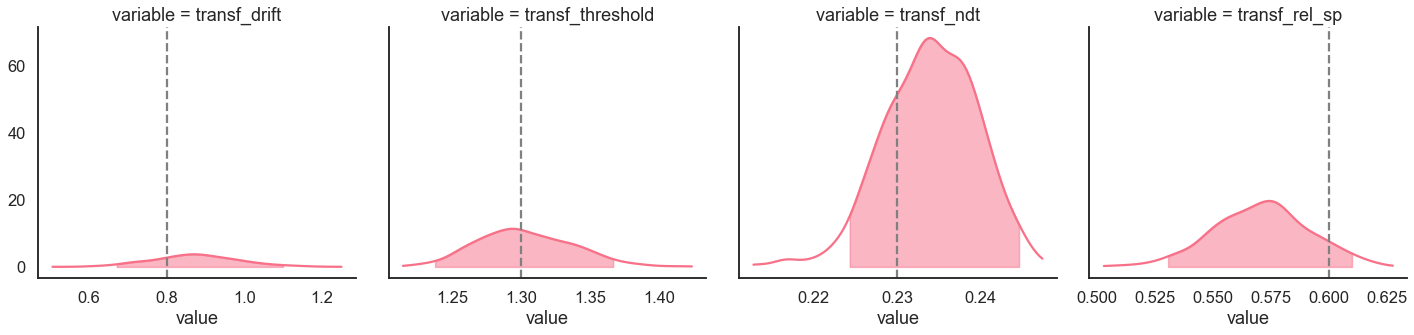

In [18]:
g = model_fit.plot_posteriors(height=5, show_intervals='HDI')

for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(data[['drift', 'threshold', 'ndt', 'rel_sp']].mean().values[i], color='grey', linestyle='--')

### Posterior predictives

#### Ungrouped posterior predictives:

In [19]:
pp = model_fit.get_posterior_predictives(n_posterior_predictives=100)

In [20]:
pp.head()

variable        rt                                                    \
trial          1         2         3         4         5         6     
sample                                                                 
1         0.387083  0.524083  0.386083  0.645083  0.678083  1.597083   
2         0.421420  0.296420  0.770420  0.356420  1.465420  0.347420   
3         0.978692  2.565692  0.379692  0.683692  0.519692  0.532692   
4         0.610303  0.538303  1.040303  0.482303  0.385303  0.576303   
5         0.409266  0.334266  0.870266  0.364266  0.629266  0.322266   

variable                                          ... accuracy                 \
trial          7         8         9         10   ...      391  392  393  394   
sample                                            ...                           
1         0.429083  0.368083  0.540083  0.536083  ...      1.0  1.0  1.0  1.0   
2         0.460420  0.694420  0.423420  0.906420  ...      1.0  1.0  1.0  0.0   
3         0.435692  0.325692  0.430692  0.654692  ...      0.0  1.0  1.0  1.0   
4         0.392303  0.443303  0.884303  1.356303  ...      1.0  1.0  1.0  1.0   
5         0.459266  0.541266  0.592266  0.616266  ...      1.0  1.0  1.0  0.0   

variable                                
trial     395  396  397  398  399  400  
sample                                  
1         1.0  1.0  1.0  1.0  1.0  1.0  
2         1.0  1.0  0.0  1.0  1.0  1.0  
3         1.0  1.0  1.0  1.0  1.0  0.0  
4         1.0  1.0  1.0  1.0  1.0  0.0  
5         0.0  1.0  1.0  0.0  0.0  1.0  

[5 rows x 800 columns]

#### Posterior predictives summaries:

In [21]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=500)

In [22]:
pp_summary.head()

,mean_acc,mean_rt,skew_rt,quant_10_rt_up,quant_30_rt_up,quant_50_rt_up,quant_70_rt_up,quant_90_rt_up,quant_10_rt_low,quant_30_rt_low,quant_50_rt_low,quant_70_rt_low,quant_90_rt_low
0,0.8125,0.632896,1.719865,0.331483,0.412283,0.500083,0.693883,1.112083,0.403883,0.458283,0.534083,0.689083,1.084883
1,0.7950,0.602282,2.749183,0.311120,0.377620,0.465420,0.596020,0.982520,0.385620,0.495720,0.571920,0.700720,1.215920
2,0.7925,0.638415,2.195681,0.307692,0.390292,0.500692,0.689292,1.090692,0.386892,0.488092,0.603692,0.848892,1.171892
3,0.7850,0.598815,1.830859,0.321203,0.386203,0.460803,0.643803,1.027803,0.344303,0.483803,0.600303,0.724303,0.983803
4,0.8000,0.631164,1.881224,0.326766,0.425966,0.543266,0.684866,1.041466,0.393066,0.499966,0.593766,0.726166,1.075366


#### Plot posterior predictives:

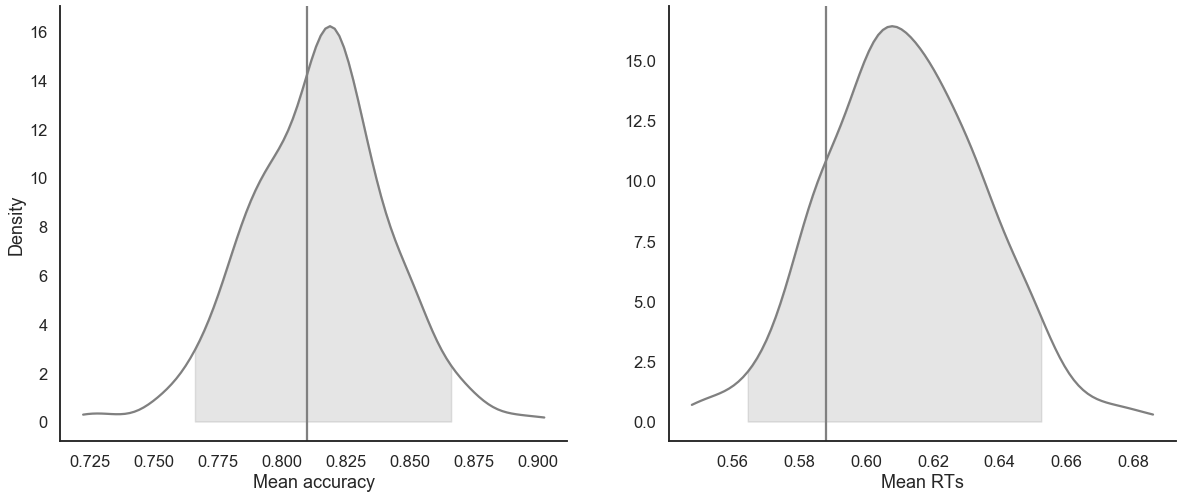

In [23]:
model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, show_intervals='HDI')

#### Plot quantiles:

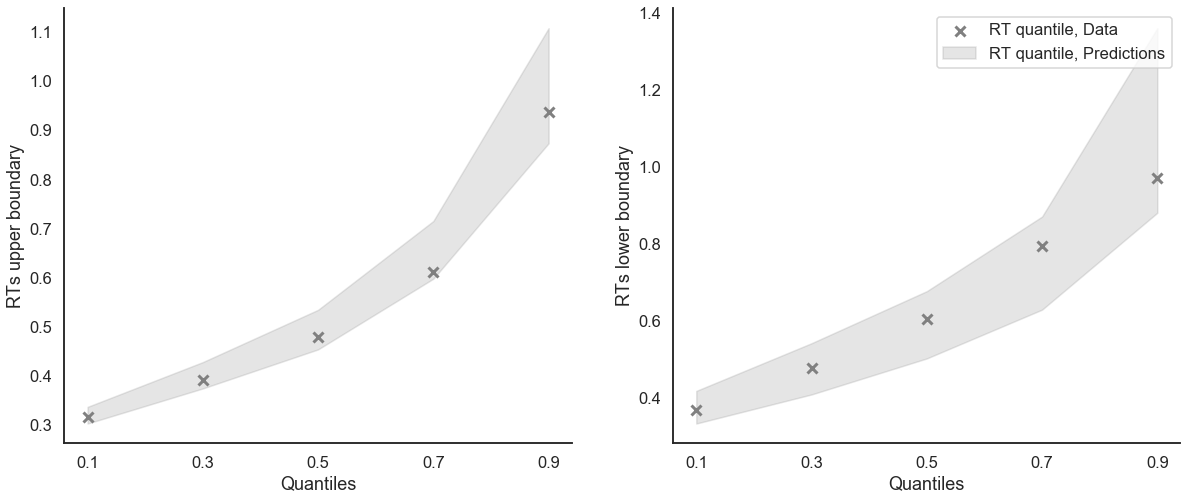

In [24]:
model_fit.plot_quantiles_posterior_predictives(kind='shades')

### Get starting values for further sampling

In [25]:
sv = model_fit.get_starting_values()
sv

,chain,draw,warmup,drift,ndt,rel_sp,threshold
499,0,499,0,0.869806,-1.436744,0.187767,0.267553
999,1,499,0,0.616195,-1.446949,0.239987,0.257146
